In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#### Загрузим и предобработаем данные

In [2]:
df = pd.read_csv('orders.csv', encoding='unicode_escape')
df.head()

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376


In [3]:
df.customer_id.isnull().any()

False

In [4]:
type(df.order_date[0])

str

In [5]:
df.order_date = pd.to_datetime(df.order_date)
df.head()

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376


In [6]:
df.order_date.dt.strftime('%Y-%m')

0       2014-09
1       2014-07
2       2014-03
3       2014-01
4       2014-04
         ...   
5004    2017-11
5005    2017-07
5006    2017-09
5007    2017-08
5008    2017-07
Name: order_date, Length: 5009, dtype: object

In [7]:
df['order_ym'] = df.order_date.dt.strftime('%Y-%m')
df.head()

,id,order_date,ship_mode,customer_id,sales,order_ym
0,100006,2014-09-07,Standard,DK-13375,377.970,2014-09
1,100090,2014-07-08,Standard,EB-13705,699.192,2014-07
2,100293,2014-03-14,Standard,NF-18475,91.056,2014-03
3,100328,2014-01-28,Standard,JC-15340,3.928,2014-01
4,100363,2014-04-08,Standard,JM-15655,21.376,2014-04


#### Так как нужно сравнить удержание в текущем и прошлом, то сравним 2016 и 2017(примем за текущий)

In [8]:
df_17 = df[df.order_date.dt.year == 2017]
df_17.head()

,id,order_date,ship_mode,customer_id,sales,order_ym
2794,100013,2017-11-06,Standard,ZC-21910,29.690,2017-11
2795,100055,2017-05-28,Standard,MD-17860,152.590,2017-05
2796,100097,2017-11-26,Second,MN-17935,1115.250,2017-11
2797,100111,2017-09-20,Standard,SV-20365,7359.918,2017-09
2798,100160,2017-09-07,Standard,CB-12025,49.688,2017-09


In [9]:
df_16 = df[df.order_date.dt.year == 2016]
df_16.head()

,id,order_date,ship_mode,customer_id,sales,order_ym
1699,100041,2016-11-20,Standard,BF-10975,328.540,2016-11
1700,100083,2016-11-24,Standard,CD-11980,24.784,2016-11
1701,100153,2016-12-13,Standard,KH-16630,63.880,2016-12
1702,100244,2016-09-20,Standard,GM-14695,475.694,2016-09
1703,100300,2016-06-24,Second,MJ-17740,4823.090,2016-06


#### Удержание в 2016

In [10]:
cohorts_16 = df_16.groupby('customer_id',as_index=False)['order_ym'].min()
cohorts_16.rename(columns = {'order_ym':'Cohort'},inplace=True)
cohorts_16.head()

,customer_id,Cohort
0,AA-10315,2016-03
1,AA-10375,2016-07
2,AA-10480,2016-07
3,AA-10645,2016-07
4,AB-10015,2016-11


In [11]:
df_merged_16 = pd.merge(df_16, cohorts_16 , how='left', on='customer_id')
df_merged_16.head()

,id,order_date,ship_mode,customer_id,sales,order_ym,Cohort
0,100041,2016-11-20,Standard,BF-10975,328.540,2016-11,2016-11
1,100083,2016-11-24,Standard,CD-11980,24.784,2016-11,2016-11
2,100153,2016-12-13,Standard,KH-16630,63.880,2016-12,2016-07
3,100244,2016-09-20,Standard,GM-14695,475.694,2016-09,2016-09
4,100300,2016-06-24,Second,MJ-17740,4823.090,2016-06,2016-04


In [12]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df

In [13]:
cohorts_group_16 = df_merged_16.groupby(['Cohort', 'order_ym']).agg({'customer_id': pd.Series.nunique})
cohorts_group_16.rename(columns={'customer_id': 'TotalUsers'}, inplace=True)
cohorts_group_16 = cohorts_group_16.groupby(level=0).apply(cohort_period)
cohorts_group_16.reset_index(inplace=True)
cohorts_group_16.set_index(['Cohort', 'CohortPeriod'], inplace=True) 
cohort_group_size_16 = cohorts_group_16['TotalUsers'].groupby(level=0).first()
user_retention_16 = cohorts_group_16['TotalUsers'].unstack(0).divide(cohort_group_size_16, axis=1)

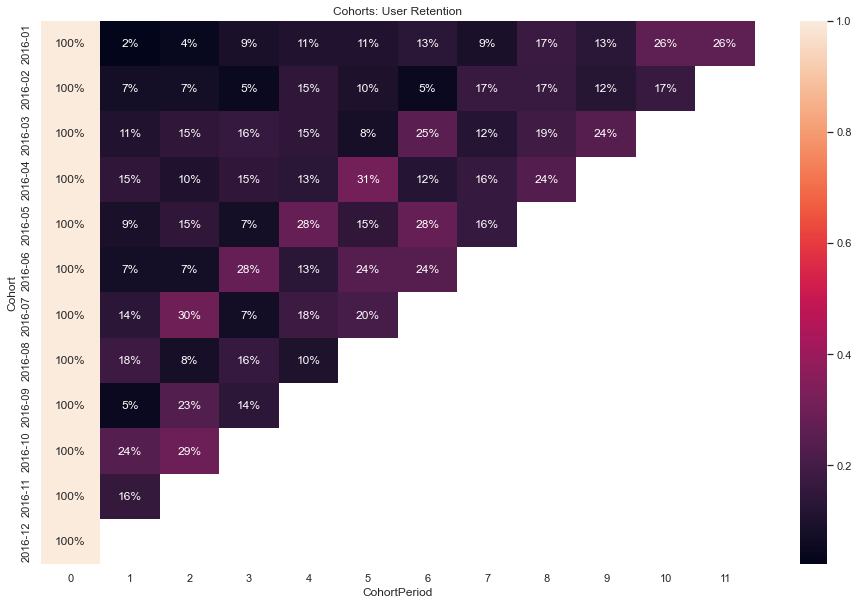

In [14]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention_16.T, mask=user_retention_16.T.isnull(), annot=True, fmt='.0%');

#### Удержание в 2017

In [15]:
cohorts_17 = df_17.groupby('customer_id',as_index=False)['order_ym'].min()
cohorts_17.rename(columns = {'order_ym':'Cohort'},inplace=True)
cohorts_17.head()

,customer_id,Cohort
0,AA-10315,2017-06
1,AA-10375,2017-09
2,AA-10480,2017-04
3,AA-10645,2017-11
4,AB-10060,2017-05


In [16]:
df_merged_17 = pd.merge(df_17, cohorts_17 , how='left', on='customer_id')
df_merged_17.head()

,id,order_date,ship_mode,customer_id,sales,order_ym,Cohort
0,100013,2017-11-06,Standard,ZC-21910,29.690,2017-11,2017-05
1,100055,2017-05-28,Standard,MD-17860,152.590,2017-05,2017-05
2,100097,2017-11-26,Second,MN-17935,1115.250,2017-11,2017-02
3,100111,2017-09-20,Standard,SV-20365,7359.918,2017-09,2017-07
4,100160,2017-09-07,Standard,CB-12025,49.688,2017-09,2017-02


In [17]:
cohorts_group_17 = df_merged_17.groupby(['Cohort', 'order_ym']).agg({'customer_id': pd.Series.nunique})
cohorts_group_17.rename(columns={'customer_id': 'TotalUsers'}, inplace=True)
cohorts_group_17 = cohorts_group_17.groupby(level=0).apply(cohort_period)
cohorts_group_17.reset_index(inplace=True)
cohorts_group_17.set_index(['Cohort', 'CohortPeriod'], inplace=True) 
cohort_group_size_17 = cohorts_group_17['TotalUsers'].groupby(level=0).first()
user_retention_17 = cohorts_group_17['TotalUsers'].unstack(0).divide(cohort_group_size_17, axis=1)

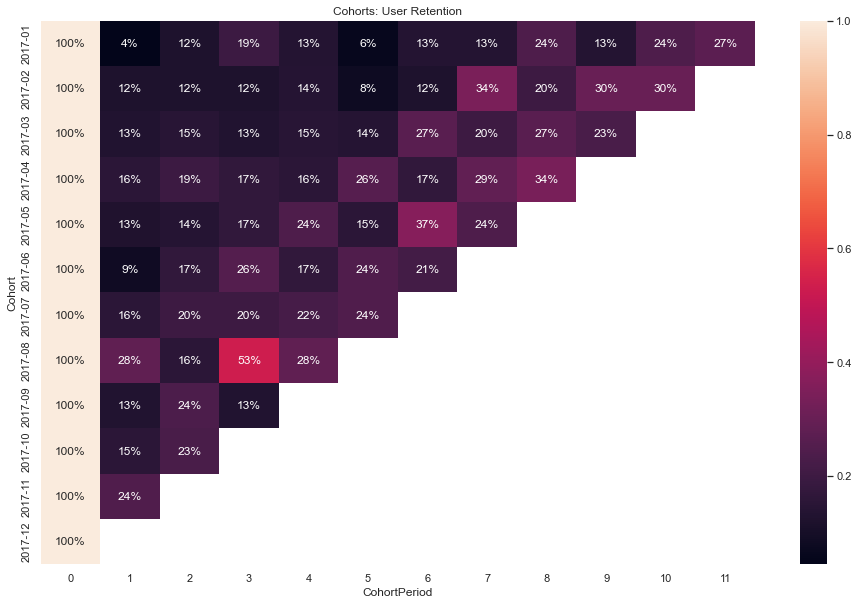

In [20]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention_17.T, mask=user_retention_17.T.isnull(), annot=True, fmt='.0%');

#### Рассмотрим retention rate относительно начала года, т.е. сколько пользователей осталось в сравнении с началом года

In [21]:
jan_user_retention_16 = np.array(user_retention_16.T.iloc[0])
jan_user_retention_17 = np.array(user_retention_17.T.iloc[0])

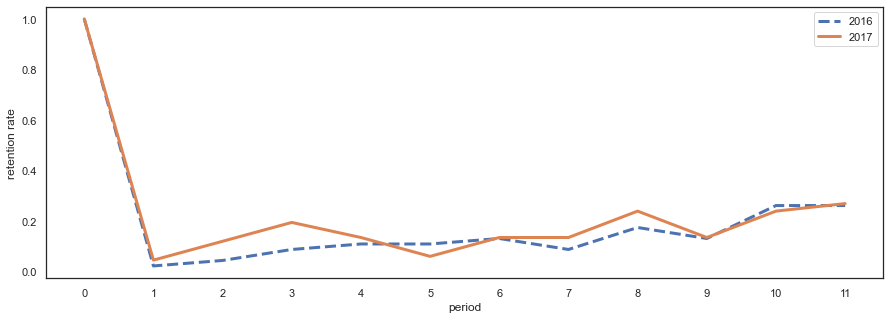

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(len(jan_user_retention_16)), jan_user_retention_16, linestyle='dashed', linewidth=3, label='2016')
plt.plot(np.arange(len(jan_user_retention_17)), jan_user_retention_17, linewidth=3, label='2017')
plt.legend()
plt.ylabel('retention rate')
plt.xlabel('period')
plt.xticks(np.arange(len(jan_user_retention_17)))
plt.show()

По графику трудно сказать стали ли больше оттекать пользователи, хотя кажется, что отток в 2017 году меньше

#### Рассмотрим статистики имеющихся выборок

In [23]:
jan_retention_df = pd.DataFrame(data={'2016': jan_user_retention_16, '2017': jan_user_retention_17})
jan_retention_df

,2016,2017
0,1.000000,1.000000
1,0.021739,0.044776
2,0.043478,0.119403
3,0.086957,0.194030
4,0.108696,0.134328
5,0.108696,0.059701
6,0.130435,0.134328
7,0.086957,0.134328
8,0.173913,0.238806
9,0.130435,0.134328


In [24]:
jan_retention_df.describe()

,2016,2017
count,12.000000,12.000000
mean,0.201087,0.225124
std,0.262204,0.253648
min,0.021739,0.044776
25%,0.086957,0.130597
50%,0.119565,0.134328
75%,0.195652,0.238806
max,1.000000,1.000000


Показатели удержания в 2017 году лучше в сравенении с 2016

Так как выборки малы и нельзя сказать, что независимы, воспользуемся криетрием Уилкоксона для зависимых выборок

    it tests whether the distribution of the differences x - y is symmetric
    about zero.
    
Альфа примем 0.05

In [25]:
from scipy.stats import wilcoxon, ttest_rel

In [26]:
wilcoxon(jan_retention_df['2017'], jan_retention_df['2016'])

C:\Users\zhiga\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=12.0, pvalue=0.06175497356189499)

По результатам теста на уровне значимости 0.05 нельзя сказать, что пользователи стали больше оттекать по сравнению с прошлым годом.

#### Инструмент для самостоятельного принятия решений по качеству удержания пользовательской базы

In [27]:
def get_cohort_retention(df_source, year_month_column_name='year_month', customer_id_column_name='customer_id'):
    """
        Возвращает rate retention по когортам
        -------------------------------------
        df_source - исходный фрейм с годовой информацией
        year_month_column_name - название столбца с датой в формате year-month
        customer_id_column_name - название столбца с id клиента
    """
    df = df_source.copy()
    cohorts = df.groupby(customer_id_column_name, as_index=False)[year_month_column_name].min()
    cohorts.rename(columns = {year_month_column_name:'Cohort'},inplace=True)
    df_merged = pd.merge(df, cohorts , how='left', on='customer_id')
    df_merged.head()
    cohorts_group = df_merged.groupby(['Cohort', year_month_column_name]).agg({customer_id_column_name: pd.Series.nunique})
    cohorts_group.rename(columns={customer_id_column_name: 'TotalUsers'}, inplace=True)
    cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
    cohorts_group.reset_index(inplace=True)
    cohorts_group.set_index(['Cohort', 'CohortPeriod'], inplace=True) 
    cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
    user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
    return user_retention.T

In [28]:
def retention_rate_test(df_new, df_old, year_month_column_name='year_month', customer_id_column_name='customer_id', is_plot=True):
    """
        Возвращает результаты критерия Уилкоксона с двусторонней альтернативой для удержания в новом и прошлом году
        -----------------------------------------------------------------------------------------------------------
        df_new - фрейм с информацией текущего года
        df_old - фрейм с информацией прошлого года
        year_month_column_name - название столбца с датой в формате year-month
        customer_id_column_name - название столбца с id клиента
    """
    jan_user_retention_new = np.array(get_cohort_retention(df_new, year_month_column_name, customer_id_column_name).iloc[0])
    jan_user_retention_old = np.array(get_cohort_retention(df_old, year_month_column_name, customer_id_column_name).iloc[0])
    if is_plot:
        plt.figure(figsize=(15, 5))
        plt.plot(np.arange(len(jan_user_retention_new)), jan_user_retention_new, linestyle='dashed', linewidth=3, label='new')
        plt.plot(np.arange(len(jan_user_retention_old)), jan_user_retention_old, linewidth=3, label='old')
        plt.legend()
        plt.ylabel('retention rate')
        plt.xlabel('period')
        plt.xticks(np.arange(len(jan_user_retention_new)))
        plt.show()
    return wilcoxon(jan_user_retention_new, jan_user_retention_old)

In [29]:
user_retention_16 = get_cohort_retention(df_16, year_month_column_name='order_ym')

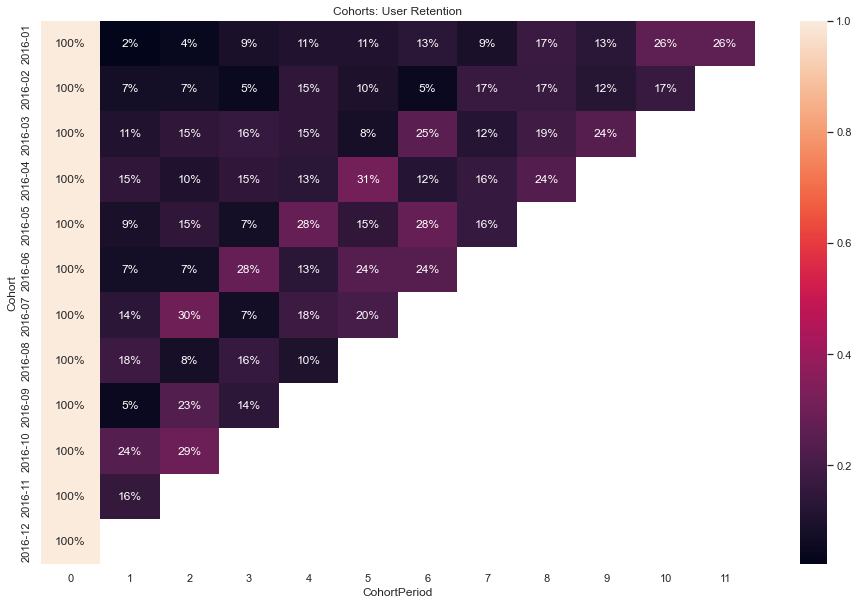

In [30]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention_16, mask=user_retention_16.isnull(), annot=True, fmt='.0%');

In [31]:
user_retention_17 = get_cohort_retention(df_17, year_month_column_name='order_ym')

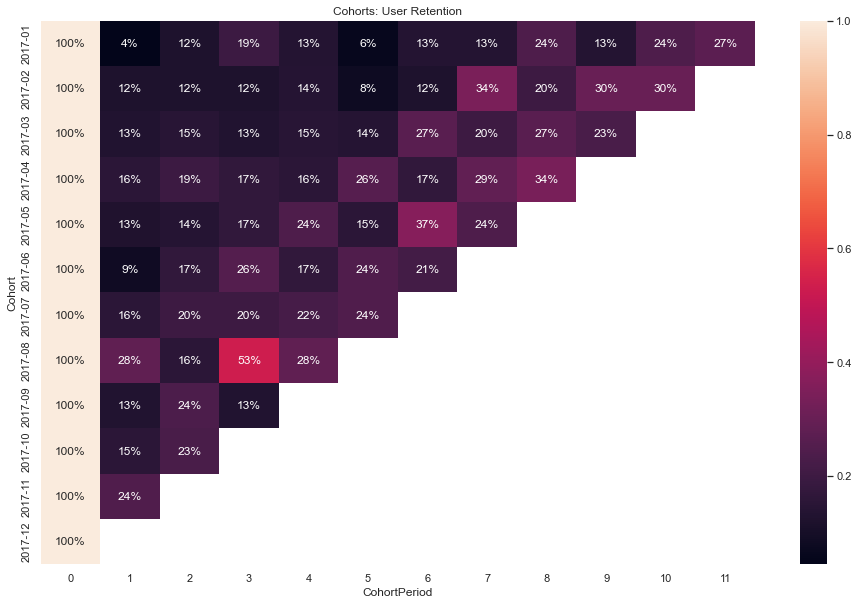

In [32]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention_17, mask=user_retention_17.isnull(), annot=True, fmt='.0%');

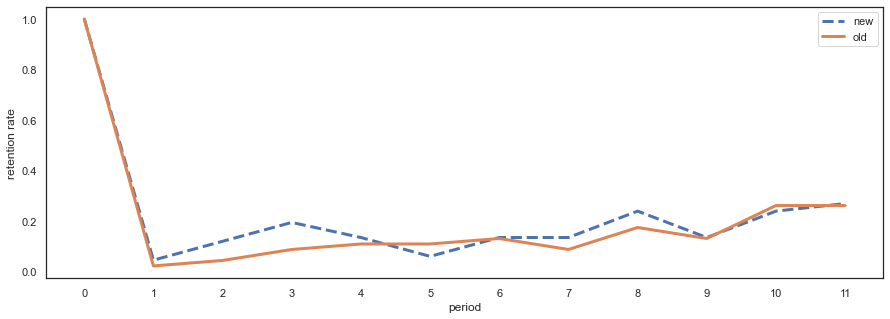

C:\Users\zhiga\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=12.0, pvalue=0.06175497356189499)

In [33]:
retention_rate_test(df_17, df_16, year_month_column_name='order_ym')